In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from scipy import constants
import function as f
from scipy.signal import find_peaks
from NewCalibration import Calib_position
from NewCalibration import Calib_energy
from NewCalibration import Calib_channel


work_dir = os.getcwd()

In [2]:
filename = '20240823_cross_section_data.txt'
filepath = os.path.join(work_dir, filename)

my_df = pd.read_csv(filepath, sep=' ', header=0)
print(len(my_df['energy']))
my_df.columns

1476315


Index(['eventnum', 'striptime', 'stripnum', 'strippos', 'energy',
       'macropulse'],
      dtype='object')

In [3]:
# extracting only data where macropulse=0 and energy !=0
index = my_df['macropulse'].loc[my_df['macropulse']==1].index
new_df = my_df.drop(index)

index_en = new_df['energy'].loc[new_df['energy']==0].index
df = new_df.drop(index_en)
df

,eventnum,striptime,stripnum,strippos,energy,macropulse
0,6533753,4.827710e+09,10,20.05980,26521.20,0
1,6533754,4.827820e+09,13,7.13431,19325.40,0
2,6533755,4.827840e+09,13,17.10300,30950.20,0
3,6533756,4.827860e+09,14,25.33490,21794.40,0
4,6533757,4.827990e+09,3,17.33490,30909.00,0
...,...,...,...,...,...,...
1413604,7947357,1.633110e+11,1,19.02130,5335.79,0
1418887,7952640,1.636680e+11,4,21.68130,10393.30,0
1446953,7980706,1.657100e+11,1,17.50430,8565.02,0
1453046,7986799,1.662070e+11,8,14.59530,419.62,0


(0.0, 4504.0)

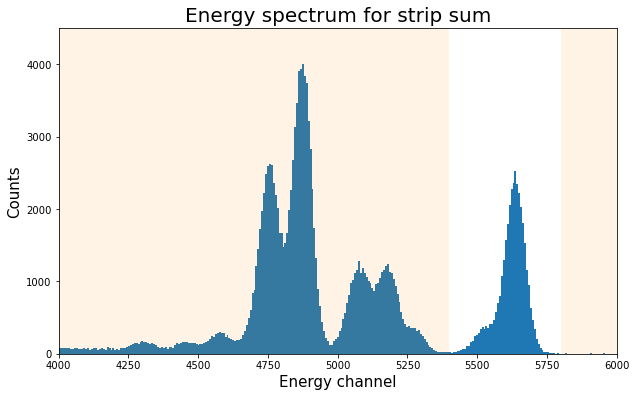

In [4]:
# plotting the energy spectrum
plt.figure(figsize=(10,6))
height, xedges, yedges = plt.hist(df['energy'], bins=5000)
plt.xlim([4000,6000])
plt.title('Energy spectrum for strip sum', fontsize=20)
plt.xlabel('Energy channel', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.axhspan(0, np.max(height)+500, 0, 0.7, facecolor='darkorange', alpha=0.1)
plt.axhspan(0, np.max(height)+500, 0.9, 1, facecolor='darkorange', alpha=0.1)
plt.ylim([0, np.max(height)+500])


23507


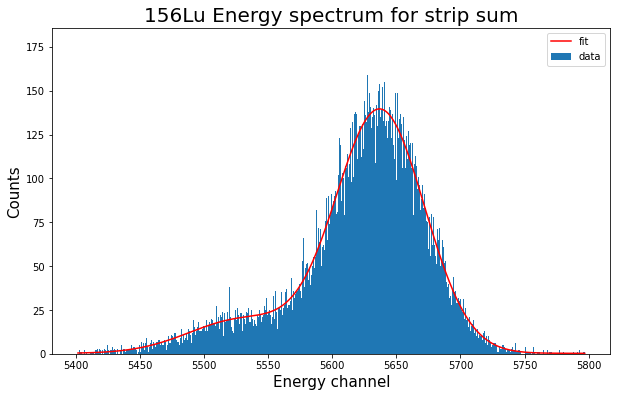

In [22]:
# I want to select only the number of counts in that energy window

cond1 = df['energy'] >= 5400
cond2 = df['energy'] <= 5800
window = np.logical_and(cond1 , cond2)

lu_df = df[window]

# plotting the energy spectrum for 156Lu
plt.figure(figsize=(10,6))
height, xedges, yedges = plt.hist(lu_df['energy'], bins=1000, label='data')
#plt.xlim([4000,6000])
plt.title('156Lu Energy spectrum for strip sum', fontsize=20)
plt.xlabel('Energy channel', fontsize=15)
plt.ylabel('Counts', fontsize=15)

plt.ylim([0, np.max(height)+20])

xcenters = (xedges[:-1]+xedges[1:])/2 # getting the centers of the bins

bin_width = xedges[1]-xedges[0]
err = np.ones(len(xcenters))*bin_width # bin width as error for fit

popt, pcov = optimize.curve_fit(f.multi_gauss2, xcenters, height, sigma=err, p0=[0, 25, 5500, 50, 150, 5625, 50]) # fit

#for ii in range(len(popt)):
#    print("pp[%d] =" % ii, popt[ii], "+/-", pcov[ii,ii]**0.5) # printing best fit parameters


plt.plot(xcenters, f.multi_gauss2(xcenters, *popt),'r-', label='fit') # plotting fit result
plt.legend()

# getting the number of counts
gauss_mean = popt[5]
gauss_FWHM = 2.35 * popt[6]

low_bound = lu_df['energy'] >= gauss_mean - gauss_FWHM/2
up_bound = lu_df['energy'] <= gauss_mean + gauss_FWHM/2
energy_range = np.logical_and(low_bound, up_bound)
final_df = lu_df[energy_range]
counts = len(final_df['energy'])
print(counts)

In [26]:
# pause correction factor
rep_rate = 5 #[Hz]
pulse_length = 3 * 10**(-3) #[s]
pcf = 1 / (1 - rep_rate * pulse_length)

# efficiency
eff = 0.30 # from literature

# counts at target
counts_at = counts * pcf / eff
print('counts at target', counts_at)

# atoms / cm^2 at target
adt = 400 * 10**(-6) #[g/cm^2]
mass = 106.9051 #[g] for 107Ag
target = adt * constants.Avogadro / mass

# atoms for beam
current = 16 * 10**(-6) #[A]
charge_state = 14
tot_meas_time = np.max(my_df['striptime']) - np.min(my_df['striptime']) * 10**(-6) #[s]
beam = current / constants.e / charge_state * tot_meas_time * rep_rate * pulse_length


# cross section
sigma = counts_at / target / beam * 10**(24)
print('cross section= %.5e barns' % sigma)

counts at target 79549.91539763114
1.602176634e-19
cross section= 1.96277e-12 barns
